In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import scipy.optimize as opt

In [181]:
Ea = 84900
R = 8.314
k0 = 2.83e13
def ktemp(T):
    return k0 * np.exp(-Ea / (R * T))

def knatural(T): #this is just natural decay
    k_nat = 0.37 #1/day
    Tref = 293 #K
    thetan = 0.951
    knatT = k_nat * (thetan**(T-Tref))
    return knatT

def ksolar(I, T): #how UV impacts decay
    k_sol = 1.8
    thetas = 1
    Tref = 293
    Icon = I*86400/1e6
    ksT = k_sol*(thetas**(T-Tref))
    ksolday = ksT*Icon
    return ksolday

def kpred(D,T): #filter feeders
    kp = 0.020
    thetap = 1
    Tref = 293
    kpT = kp*(thetap**(T-Tref))
    kpday = kpT*D
    return kpday

def ktot(T,I,D): #total kinetics
    return knatural(T)+ksolar(I, T) + kpred(D,T)

def pkc(ci, cstar, k, tau, P):
    co = cstar + (ci-cstar)/((1 + k*tau/P)**P)
    return co

def pkc_dyman(t, c, ci, cstar, k, tau, P):
    taueffect = tau/P
    dcdt = (1/taueffect) * (ci-c) -k*(c-cstar)
    return [dcdt]
    

#initial parameters
V = 1000 
Q = 14
T = 298 #initial values from paper Hernandez-Crespo
Isol = 200
Ddap = 10

tau_tw1 = 5.5
tau_tw2 = 2.6
Vtw1 = Q* tau_tw1
Vtw2 = Q*tau_tw2


ci = 1.7e5 #inlet concentration
ci_tw1 = 1.74e6  # TW1 inlet
ci_tw2 = 1.57e5 
cstar = 100 #background concentration

ktw1 = 2.14
ktw2 = 1.86
thetaTW1 = 0.999
thetaTW2 = 0.983
P = 1.5 #tanks in series
tau = V/Q
k = ktot(T,Isol, Ddap)

In [182]:
#steady state
co_tw1 = pkc(ci_tw1, cstar, ktw1, tau_tw1, P)
co_tw2 = pkc(ci_tw2, cstar, ktw2, tau_tw2, P)

#removal efficiencies
removal_tw1 = (1 - co_tw1 / ci_tw1) * 100
removal_tw2 = (1 - co_tw2 / ci_tw2) * 100
log_removal_tw1 = np.log10(ci_tw1 / co_tw1)
log_removal_tw2 = np.log10(ci_tw2 / co_tw2)
overall_removal = (1 - co_tw2 / ci) * 100
overall_log_removal = np.log10(ci / co_tw2)

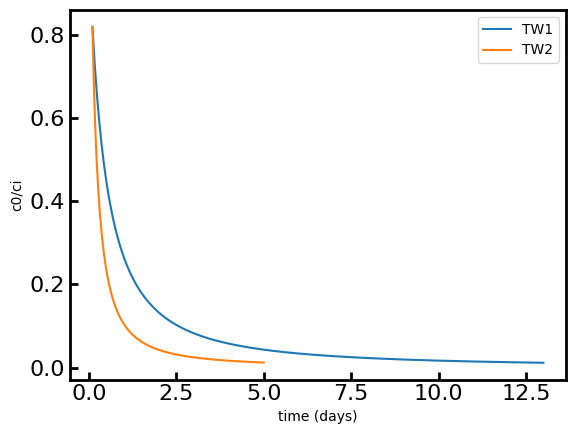

In [183]:
hrt_rangetw1 = np.linspace(0.1, 13, 200)
coci1 = [pkc(ci_tw1, cstar, ktw1, hrt, P)/ci_tw1 for hrt in hrt_rangetw1]
plt.plot(hrt_rangetw1, coci1, label='TW1')

hrt_rangetw2= np.linspace(0.1, 5, 200)
coci2 = [pkc(ci_tw2, cstar, ktw1, hrt, P)/ci_tw2 for hrt in hrt_rangetw1]
plt.plot(hrt_rangetw2, coci2, label='TW2')


plt.tick_params(direction='in', width=2, length=6, labelsize=16)
#plt.xticks([0, 20, 40, 60, 80, 100])
plt.minorticks_off()
ax = plt.gca()  # get current axes
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.xlabel('time (days)')
plt.ylabel('c0/ci')
plt.legend()

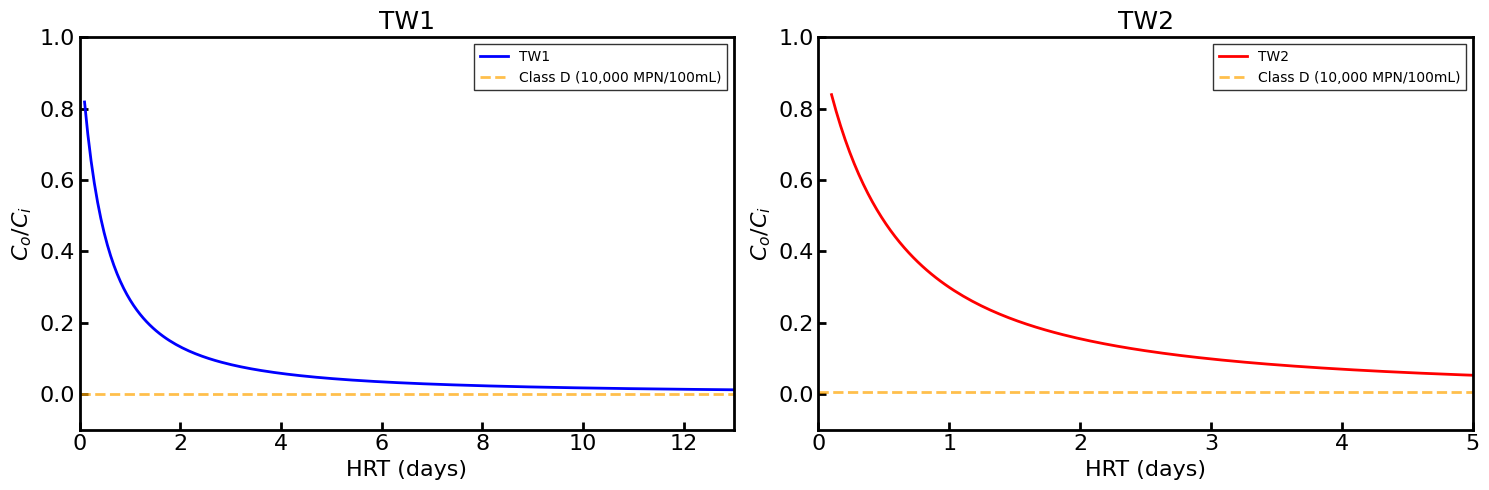

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

threshold_D_tw1 = 1000 / ci_tw1
#regulatory mclimit

threshold_D_tw2 = 1000 / ci_tw2
# TW1 plot
hrt_rangetw1 = np.linspace(0.1, 13, 200)
coci1 = [pkc(ci_tw1, cstar, ktw1, hrt, P)/ci_tw1 for hrt in hrt_rangetw1]
ax1.plot(hrt_rangetw1, coci1, 'b-', linewidth=2, label='TW1')
ax1.axhline(y=threshold_D_tw1, color='orange', linestyle='--', linewidth=2,
            label=f'Class D (10,000 MPN/100mL)', alpha=0.7)
ax1.tick_params(direction='in', width=2, length=6, labelsize=16)
ax1.minorticks_off()
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.set_xlabel('HRT (days)', fontsize=16)
ax1.set_ylabel('$C_o/C_i$', fontsize=16)
ax1.set_title('TW1', fontsize=18)
ax1.set_xlim([0, 13])
ax1.set_ylim([-0.1, 1])
ax1.legend(loc='upper right', edgecolor='black', fancybox=False)

# TW2 plot
hrt_rangetw2 = np.linspace(0.1, 7, 200)
coci2 = [pkc(ci_tw2, cstar, ktw2, hrt, P)/ci_tw2 for hrt in hrt_rangetw2] 
ax2.plot(hrt_rangetw2, coci2, 'r-', linewidth=2, label='TW2')
ax2.axhline(y=threshold_D_tw2, color='orange', linestyle='--', linewidth=2,
            label=f'Class D (10,000 MPN/100mL)', alpha=0.7)

ax2.tick_params(direction='in', width=2, length=6, labelsize=16)
ax2.minorticks_off()
for spine in ax2.spines.values():
    spine.set_linewidth(2)
ax2.set_xlabel('HRT (days)', fontsize=16)
ax2.set_ylabel('$C_o/C_i$', fontsize=16)
ax2.set_title('TW2', fontsize=18)
ax2.set_xlim([0, 5])
ax2.set_ylim([-0.1, 1])
ax2.legend(loc='upper right', edgecolor='black', fancybox=False)

plt.tight_layout()
plt.savefig('individualsystem.png',dpi=300,transparent=True)

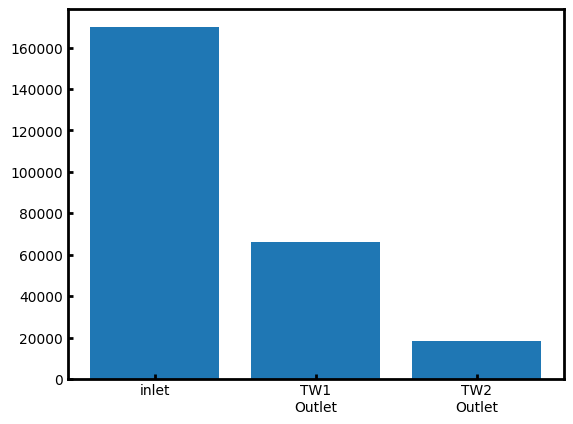

In [185]:
#total system time, and treatment
stages = ['inlet', 'TW1\nOutlet', 'TW2\nOutlet']
conc = [ci, co_tw1, co_tw2]
bars = plt.bar(stages, conc)
plt.tick_params(direction='in', width=2)
plt.minorticks_off()
ax = plt.gca()  # get current axes
for spine in ax.spines.values():
    spine.set_linewidth(2)
#plt.savefig('barsystem.png',dpi=300,transparent=True)

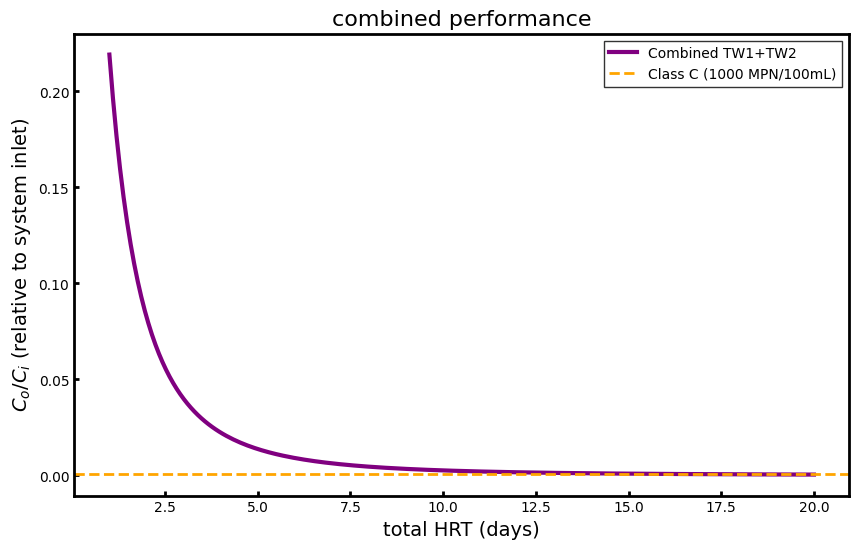

In [212]:
# combined TW1 + TW2 performance
def combined_system(hrt_tw1, hrt_tw2):
    co_tw1 = pkc(ci_tw1, cstar, ktw1, hrt_tw1, P)  # TW1 outlet
    co_tw2 = pkc(co_tw1, cstar, ktw2, hrt_tw2, P)  # TW2 outlet (uses TW1 outlet as input)
    return co_tw2


total_hrt_range = np.linspace(1, 20, 200)
combined_coci = []
for total_hrt in total_hrt_range:
    hrt1 = total_hrt * 0.68  # 68% in TW1
    hrt2 = total_hrt * 0.32  # 32% in TW2
    co_combined = combined_system(hrt1, hrt2)
    combined_coci.append(co_combined / ci_tw1)

plt.figure(figsize=(10, 6))
plt.plot(total_hrt_range, combined_coci, 'purple', linewidth=3, label='Combined TW1+TW2')

threshold_C_combined = 1000 / ci_tw1
plt.axhline(y=threshold_C_combined, color='orange', linestyle='--', linewidth=2,
            label='Class C (1000 MPN/100mL)')

plt.xlabel('total HRT (days)', fontsize=14)
plt.ylabel('$C_o/C_i$ (relative to system inlet)', fontsize=14)
plt.title('combined performance', fontsize=16)
plt.legend()
plt.tick_params(direction='in', width=2)
plt.minorticks_off()
ax = plt.gca()  # get current axes
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.legend(loc='upper right', edgecolor='black', fancybox=False)
plt.savefig('combinedsystem.png',dpi=300,transparent=True)

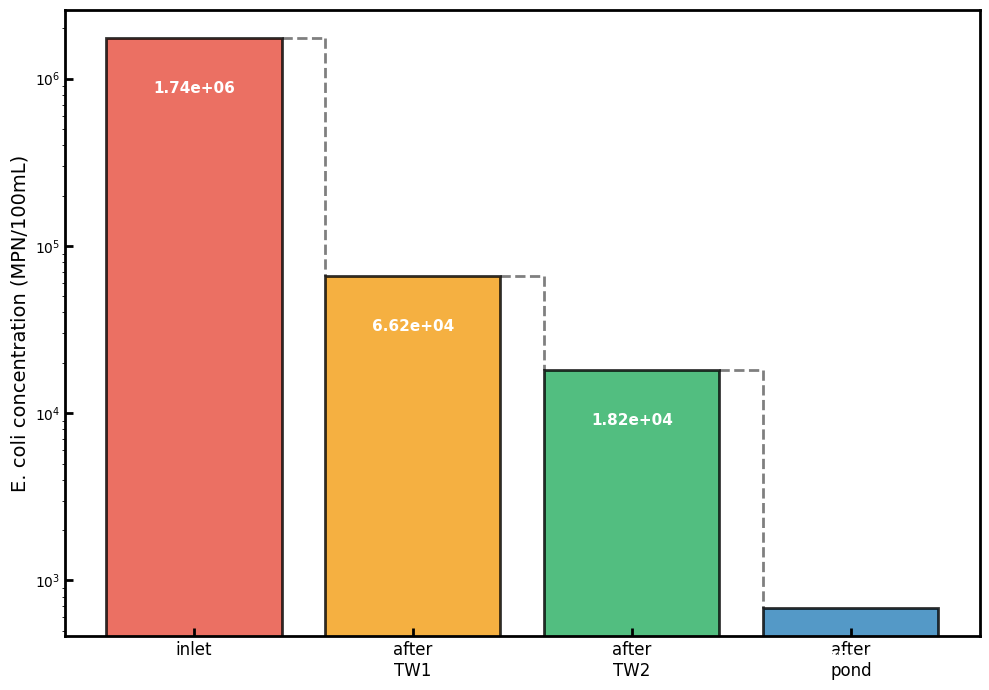

In [261]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 7))


stages = ['inlet', 'after\nTW1', 'after\nTW2', 'after\npond']
concentrations = [ci_tw1, co_tw1, co_tw2, 685]
colors = ['#e74c3c', '#f39c12', '#27ae60', '#2980b9']

removals = [0] + [concentrations[i] - concentrations[i+1] for i in range(len(concentrations)-1)]

x_pos = np.arange(len(stages))
bottom = 0

for i, (stage, conc, removal, color) in enumerate(zip(stages, concentrations, removals, colors)):
    if i == 0:

        ax.bar(i, conc, color=color, edgecolor='black', linewidth=2, alpha=0.8)
        ax.text(i, conc/2, f'{conc:.2e}', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    else:

        ax.bar(i, conc, bottom=0, color=color, edgecolor='black', linewidth=2, alpha=0.8)
        ax.text(i, conc/2, f'{conc:.2e}', ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')

        ax.plot([i-1+0.4, i-0.4], [concentrations[i-1], concentrations[i-1]], 
                'k--', linewidth=2, alpha=0.5)
        ax.plot([i-0.4, i-0.4], [concentrations[i-1], conc],
                'k--', linewidth=2, alpha=0.5)


ax.set_xticks(x_pos)
ax.set_xticklabels(stages, fontsize=12)
ax.set_ylabel('E. coli concentration (MPN/100mL)', fontsize=14)
ax.set_yscale('log')

ax.tick_params(direction='in', width=2, length=6)
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig('barsystem.png',dpi=300,transparent=True)

In [225]:
Q = 14 
ci_tw1 = 1.74e6
cstar = 100
k_tw1_base = 2.14
k_tw2_base = 1.86
P_base = 1
T_base = 298 


V_tw1_current = 77
V_tw2_current = 36
tau_tw1_current = V_tw1_current / Q
tau_tw2_current = V_tw2_current / Q


co_tw1_base = pkc(ci_tw1, cstar, k_tw1_base, tau_tw1_current, P_base)
co_tw2_base = pkc(co_tw1_base, cstar, k_tw2_base, tau_tw2_current, P_base)
removal_base = (1 - co_tw2_base / ci_tw1) * 100

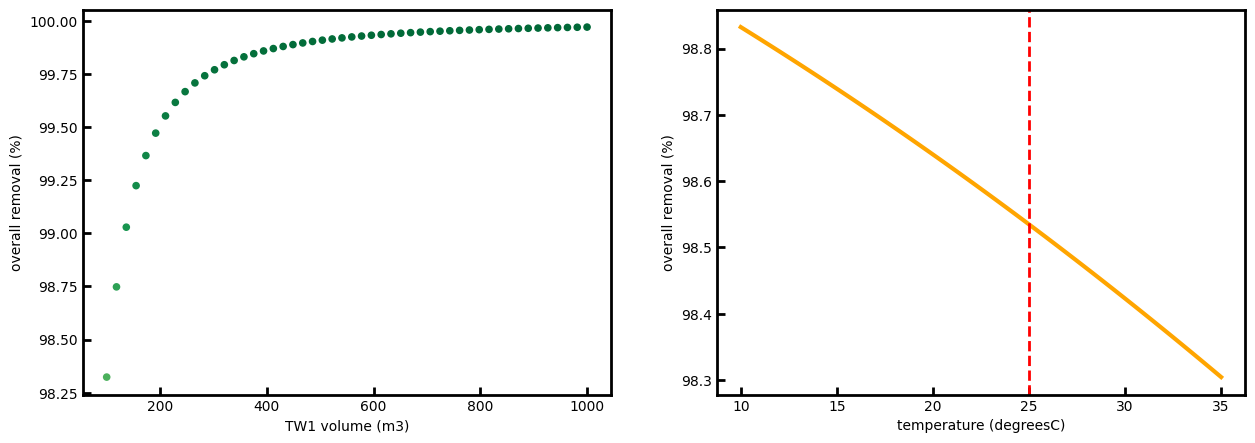

In [262]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# volume
V_range = np.linspace(100, 1000, 50)
outlet_conc = []
removal_eff = []
for Vtot in V_range:
    V1 = Vtot * 0.68
    V2 = Vtot * 0.32
    tau1 = V1 / Q
    tau2 = V2 / Q
    
    co1 = pkc(ci_tw1, cstar, k_tw1_base, tau1, P_base)
    co2 = pkc(co1, cstar, k_tw2_base, tau2, P_base)
    outlet_conc.append(co2)
    removal_eff.append((1 - co2/ci_tw1) * 100)

ax1.scatter(V_range, removal_eff, c=removal_eff, cmap='RdYlGn', s=20, vmin=90, vmax=100)

ax1.set_xlabel('TW1 volume (m3)')
ax1.set_ylabel('overall removal (%)')
#ax1.set_title('sensitivity to system volume')
ax1.tick_params(direction='in', width=2, length=6)
for spine in ax1.spines.values():
    spine.set_linewidth(2)

T_range = np.linspace(283, 308, 50) 
theta_tw1 = 0.999  # paper
theta_tw2 = 0.983
T_ref = 293  #reference

removal_eff_T = []
outlet_conc_T = []

for T in T_range:
    k_tw1_T = k_tw1_base * (theta_tw1 ** (T - T_ref))
    k_tw2_T = k_tw2_base * (theta_tw2 ** (T - T_ref))
    
    co1 = pkc(ci_tw1, cstar, k_tw1_T, tau_tw1_current, P_base)
    co2 = pkc(co1, cstar, k_tw2_T, tau_tw2_current, P_base)
    outlet_conc_T.append(co2)
    removal_eff_T.append((1 - co2/ci_tw1) * 100)

T_celsius = T_range - 273
ax2.plot(T_celsius, removal_eff_T, 'orange', linewidth=3)
ax2.axvline(x=T_base-273, color='red', linestyle='--', linewidth=2,
            label=f'Current: {T_base-273:.0f}°C')
ax2.set_xlabel('temperature (degreesC)')
ax2.set_ylabel('overall removal (%)')
ax2.tick_params(direction='in', width=2, length=6)
for spine in ax2.spines.values():
    spine.set_linewidth(2)
    
plt.savefig('sensitivitysystem.png',dpi=300,transparent=True)